# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

In [1]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [2]:
tf.__version__

'1.15.2'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7841070266563893664,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9992663860
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9531924460356009646
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 9993660007
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2001665883431730598
 physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5"]

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [4]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
tar: Error opening archive: Failed to open 'images.tar.gz'
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [4]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = tf.keras.utils.to_categorical(batch_y)
    # batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [5]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [6]:
x, y= next(train_generator)

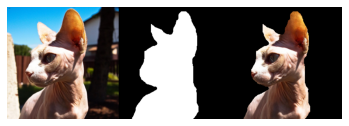

In [7]:
plt.axis('off')
img = x[0]
msk = y[0,:,:,1]
# msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [8]:
def mean_iou_binary(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [31]:
def mean_iou(y_true, y_pred):
  # B, H, W, 2
    yt0 = y_true[:,:,:,1]
    yp0 = tf.argmax(y_pred, axis=-1)
    yp0 = K.cast(yp0, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

residual model


# Model

In [10]:
def conv_block(x, nKernels=32, kernel_size=3):
  cov = Conv2D(nKernels, kernel_size, kernel_initializer='he_normal', use_bias=False, padding='same')(x)
  bn = BatchNormalization()(cov)
  act = Activation('relu')(bn)

  return act

In [11]:
def residual_block(x, nKernels=16, kernel_size=3):
  indentity = x
  BN1 = BatchNormalization()(x)
  Act1 = Activation('relu')(BN1)
  Conv1 = Conv2D(nKernels, kernel_size, kernel_initializer='he_normal', use_bias=False, padding='same')(Act1)
  BN2 = BatchNormalization()(Conv1)
  Act2 = Activation('relu')(BN2)
  Conv2 = Conv2D(nKernels, kernel_size, kernel_initializer='he_normal', use_bias=False, padding='same')(Act2)
  
  return Conv2 + indentity


In [12]:
def unet(sz = (256, 256, 3)):
  # Input layer

  nKernels = 16

  x = Input(sz)
  # (256,256,3)
  encoding = Conv2D(nKernels, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  layer11 = residual_block(encoding, nKernels)
  layer12 = MaxPooling2D()(layer11)

  # (128,128,32)
  layer21 = residual_block(layer12, nKernels)
  layer22 = MaxPooling2D()(layer21)

  # (64,64,64)
  layer31 = residual_block(layer22, nKernels)
  layer32 = MaxPooling2D()(layer31)

  # (32,32,128)
  layer41 = residual_block(layer32, nKernels)
  layer42 = MaxPooling2D()(layer41)

  # (16,16,256)
  layer51 = residual_block(layer42, nKernels)
  layer52 = MaxPooling2D()(layer51) #(16,16,512)

  # (8,8,512)
  bottleneck = Conv2D(nKernels*32, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer52)
  bottleneck = Dropout(0.25)(bottleneck)
  # (8,8,1024)
  bottleneck2 = Conv2D(nKernels*16, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(bottleneck)
  # (8,8,512)

  layer61 = UpSampling2D()(bottleneck2)
  layer62 = Concatenate(axis=-1)([layer61, layer51]) #(16,16,1024)
  layer62 = Conv2D(nKernels, (1,1), kernel_initializer='he_normal', activation='relu', padding='same')(layer62)
  layer63 = residual_block(layer62, nKernels)

  layer71 = UpSampling2D()(layer63) #(32,32,256)
  layer72 = Concatenate()([layer71, layer41])
  layer72 = Conv2D(nKernels, (1,1), kernel_initializer='he_normal', activation='relu', padding='same')(layer72)
  layer73 = residual_block(layer72, nKernels)

  layer81 = UpSampling2D()(layer73)
  layer82 = Concatenate()([layer81, layer31])
  layer82 = Conv2D(nKernels, (1,1), kernel_initializer='he_normal', activation='relu', padding='same')(layer82)
  layer83 = residual_block(layer82, nKernels)

  layer91 = UpSampling2D()(layer83)
  layer92 = Concatenate()([layer91, layer21])
  layer92 = Conv2D(nKernels, (1,1), kernel_initializer='he_normal', activation='relu', padding='same')(layer92)
  layer93 = residual_block(layer92, nKernels)

  layer101 = UpSampling2D()(layer93)
  layer102= Concatenate()([layer101, layer11])  
  layer102 = Conv2D(nKernels, (1,1), kernel_initializer='he_normal', activation='relu', padding='same')(layer102)
  layer103 = residual_block(layer102, nKernels)

  last = Conv2D(2, (1,1), activation='softmax')(layer103)

  #model creation 
  model = Model(inputs=[x], outputs=[last])
  model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = [mean_iou])
  
  return model



In [32]:
# 녹색 선 = 3x3 convolutional
def Mnet(sz = (256, 256, 3)):
    
    nKernels = 16
    
    x = Input(sz)
    # (256, 256, 3)
    layer11 = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
    layer12 = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer11)
    layer13 = Concatenate()([layer11, layer12])
    layer14 = Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer13)
    
    layer11p = MaxPooling2D()(layer11)
    layer14p = MaxPooling2D()(layer14)
    layer21 = Concatenate()([layer11p, layer14p])
    layer22 = Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer21)
    layer23 = Concatenate()([layer22, layer14p])
    layer24 = Conv2D(48, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer23)
    
    layer11pp = MaxPooling2D()(layer11p)
    layer24p = MaxPooling2D()(layer24)
    layer31 = Concatenate()([layer11pp, layer24p])
    layer32 = Conv2D(48, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer31)
    layer33 = Concatenate()([layer32, layer24p])
    layer34 = Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer33)
    
    layer11ppp = MaxPooling2D()(layer11pp)
    layer34p = MaxPooling2D()(layer34)
    layer41 = Concatenate()([layer11ppp, layer34p])
    layer42 = Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer41)
    layer43 = Concatenate()([layer42, layer34p])
    
    layer44 = Conv2D(128, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer43)
    
    layer45 = Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer44)

    layer45u = UpSampling2D()(layer45)
    layer51 = Concatenate(axis=-1)([layer45u, layer34])
    layer52 = Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer51)
    layer53 = Concatenate()([layer52, layer45u])
    layer54 = Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer53)
    layer55 = Concatenate()([layer54, layer45u])

    layer54u = UpSampling2D()(layer54)
    layer61 = Concatenate()([layer54u, layer24])
    layer62 = Conv2D(48, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer61)
    layer63 = Concatenate()([layer62, layer54u])
    layer64 = Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer63)
    layer55u = UpSampling2D()(layer55)
    layer65 = Concatenate()([layer55u, layer64])

    layer64u = UpSampling2D()(layer64)
    layer71 = Concatenate()([layer14, layer64u])
    layer72 = Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer71)
    layer73 = Concatenate()([layer72, layer64u])
    layer74 = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer73)
    layer65u = UpSampling2D()(layer65)
    layer75 = Concatenate()([layer74, layer65u])

    last = Conv2D(2, (1, 1), activation='softmax')(layer75)

    #model creation 
    model = Model(inputs=[x], outputs=[last])
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = [mean_iou])

    return model

In [33]:
model = Mnet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [26]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('\ni=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk = pred[0]
        msk = np.argmax(msk, axis=-1)
    
        # pred (B, W, H, C)
        # msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
    
        # msk[msk >= 0.5] = 1 
        # msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

Epoch 1/30
 11/219 [>.............................] - ETA: 36s - loss: 0.4766 - mean_iou: 0.1040i= 1 loss= 0.6089595407927961 val_loss= 0.47659018906680023 mean_iou= 0.23423351 val_mean_iou= 0.103983425


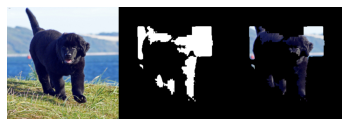

219/219 [==============================] - 75s 340ms/step - loss: 0.6090 - mean_iou: 0.2342 - val_loss: 0.4766 - val_mean_iou: 0.1040
Epoch 2/30
 11/219 [>.............................] - ETA: 35s - loss: 0.4003 - mean_iou: 0.1138i= 2 loss= 0.46386554810010133 val_loss= 0.4003245342861522 mean_iou= 0.13907674 val_mean_iou= 0.113846205


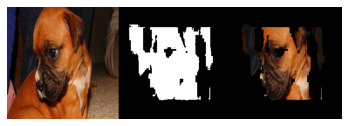

219/219 [==============================] - 69s 316ms/step - loss: 0.4639 - mean_iou: 0.1391 - val_loss: 0.4003 - val_mean_iou: 0.1138
Epoch 3/30
 11/219 [>.............................] - ETA: 36s - loss: 0.4033 - mean_iou: 0.1401i= 3 loss= 0.4269257061285515 val_loss= 0.40332272377881134 mean_iou= 0.1302475 val_mean_iou= 0.14012204


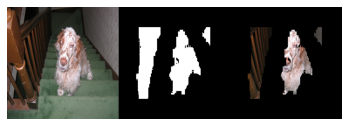

219/219 [==============================] - 69s 316ms/step - loss: 0.4269 - mean_iou: 0.1302 - val_loss: 0.4033 - val_mean_iou: 0.1401
Epoch 4/30
 11/219 [>.............................] - ETA: 35s - loss: 0.3400 - mean_iou: 0.1002i= 4 loss= 0.38282583198046577 val_loss= 0.3400259857827967 mean_iou= 0.10748564 val_mean_iou= 0.10024583


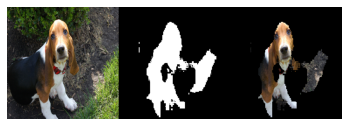

219/219 [==============================] - 69s 315ms/step - loss: 0.3828 - mean_iou: 0.1075 - val_loss: 0.3400 - val_mean_iou: 0.1002
Epoch 5/30
 11/219 [>.............................] - ETA: 36s - loss: 0.4130 - mean_iou: 0.1785i= 5 loss= 0.3582733681757156 val_loss= 0.41299527612599457 mean_iou= 0.09551065 val_mean_iou= 0.17847203


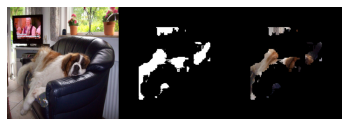

219/219 [==============================] - 69s 315ms/step - loss: 0.3583 - mean_iou: 0.0955 - val_loss: 0.4130 - val_mean_iou: 0.1785
Epoch 6/30
 11/219 [>.............................] - ETA: 35s - loss: 0.3072 - mean_iou: 0.1001i= 6 loss= 0.3298967953550217 val_loss= 0.307188941673799 mean_iou= 0.085158944 val_mean_iou= 0.10010149


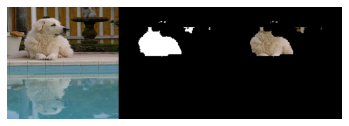

219/219 [==============================] - 69s 315ms/step - loss: 0.3299 - mean_iou: 0.0852 - val_loss: 0.3072 - val_mean_iou: 0.1001
Epoch 7/30
 11/219 [>.............................] - ETA: 35s - loss: 0.3053 - mean_iou: 0.0544i= 7 loss= 0.3049371649413348 val_loss= 0.3053246655247428 mean_iou= 0.07649444 val_mean_iou= 0.054435644


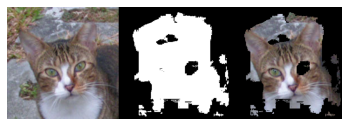

219/219 [==============================] - 69s 316ms/step - loss: 0.3049 - mean_iou: 0.0765 - val_loss: 0.3053 - val_mean_iou: 0.0544
Epoch 8/30
 11/219 [>.............................] - ETA: 35s - loss: 0.3868 - mean_iou: 0.0374i= 8 loss= 0.2948014987930315 val_loss= 0.38677774234251544 mean_iou= 0.07163049 val_mean_iou= 0.03740473


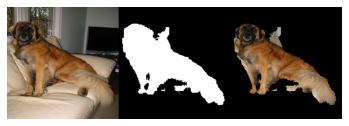

219/219 [==============================] - 69s 315ms/step - loss: 0.2948 - mean_iou: 0.0716 - val_loss: 0.3868 - val_mean_iou: 0.0374
Epoch 9/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2638 - mean_iou: 0.0746i= 9 loss= 0.2737891309337529 val_loss= 0.2638318335468119 mean_iou= 0.06555325 val_mean_iou= 0.074596815


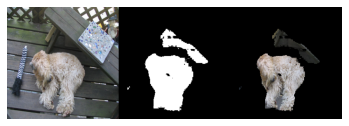

219/219 [==============================] - 69s 315ms/step - loss: 0.2738 - mean_iou: 0.0656 - val_loss: 0.2638 - val_mean_iou: 0.0746
Epoch 10/30
 11/219 [>.............................] - ETA: 34s - loss: 0.2962 - mean_iou: 0.1127i= 10 loss= 0.2667572061492972 val_loss= 0.2961866638877175 mean_iou= 0.06328411 val_mean_iou= 0.11270756


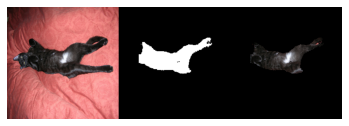

219/219 [==============================] - 69s 314ms/step - loss: 0.2668 - mean_iou: 0.0633 - val_loss: 0.2962 - val_mean_iou: 0.1127
Epoch 11/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2636 - mean_iou: 0.0807i= 11 loss= 0.25381222823166955 val_loss= 0.2635624557733536 mean_iou= 0.058944933 val_mean_iou= 0.08073792


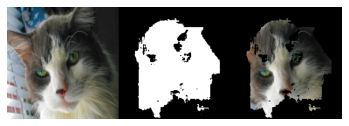

219/219 [==============================] - 69s 316ms/step - loss: 0.2538 - mean_iou: 0.0589 - val_loss: 0.2636 - val_mean_iou: 0.0807
Epoch 12/30
 11/219 [>.............................] - ETA: 34s - loss: 0.2591 - mean_iou: 0.0446i= 12 loss= 0.24455038679244856 val_loss= 0.25905992361632263 mean_iou= 0.05621542 val_mean_iou= 0.044643823


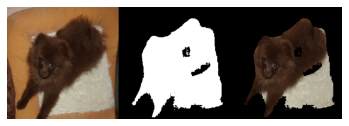

219/219 [==============================] - 69s 314ms/step - loss: 0.2446 - mean_iou: 0.0562 - val_loss: 0.2591 - val_mean_iou: 0.0446
Epoch 13/30
 11/219 [>.............................] - ETA: 34s - loss: 0.2660 - mean_iou: 0.0882i= 13 loss= 0.23731095585376705 val_loss= 0.2659793076190082 mean_iou= 0.054541364 val_mean_iou= 0.08822891


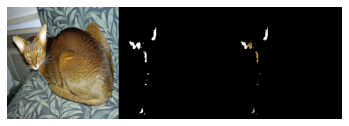

219/219 [==============================] - 69s 314ms/step - loss: 0.2373 - mean_iou: 0.0545 - val_loss: 0.2660 - val_mean_iou: 0.0882
Epoch 14/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2818 - mean_iou: 0.0259i= 14 loss= 0.22848813725660924 val_loss= 0.2817574373700402 mean_iou= 0.051869653 val_mean_iou= 0.025933374


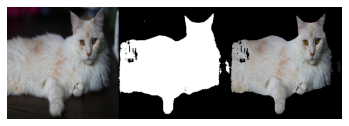

219/219 [==============================] - 69s 314ms/step - loss: 0.2285 - mean_iou: 0.0519 - val_loss: 0.2818 - val_mean_iou: 0.0259
Epoch 15/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2967 - mean_iou: 0.1124i= 15 loss= 0.22581212617218765 val_loss= 0.2967104126106609 mean_iou= 0.051010758 val_mean_iou= 0.1124445


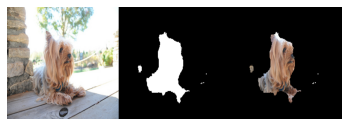

219/219 [==============================] - 69s 314ms/step - loss: 0.2258 - mean_iou: 0.0510 - val_loss: 0.2967 - val_mean_iou: 0.1124
Epoch 16/30
 11/219 [>.............................] - ETA: 35s - loss: 0.1990 - mean_iou: 0.0388i= 16 loss= 0.21623108376106714 val_loss= 0.19897608188065616 mean_iou= 0.04855692 val_mean_iou= 0.03879683


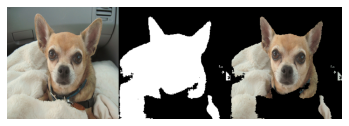

219/219 [==============================] - 69s 315ms/step - loss: 0.2162 - mean_iou: 0.0486 - val_loss: 0.1990 - val_mean_iou: 0.0388
Epoch 17/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2193 - mean_iou: 0.0409i= 17 loss= 0.21275754150462478 val_loss= 0.21926603804935108 mean_iou= 0.04745523 val_mean_iou= 0.040933143


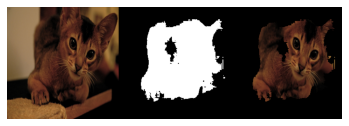

219/219 [==============================] - 69s 315ms/step - loss: 0.2128 - mean_iou: 0.0475 - val_loss: 0.2193 - val_mean_iou: 0.0409
Epoch 18/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2243 - mean_iou: 0.0339i= 18 loss= 0.20660225924563735 val_loss= 0.22427862747149033 mean_iou= 0.04604871 val_mean_iou= 0.033851437


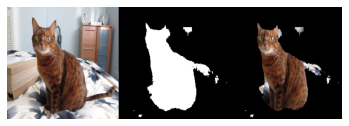

219/219 [==============================] - 69s 314ms/step - loss: 0.2066 - mean_iou: 0.0460 - val_loss: 0.2243 - val_mean_iou: 0.0339
Epoch 19/30
 11/219 [>.............................] - ETA: 35s - loss: 0.1951 - mean_iou: 0.0320i= 19 loss= 0.20088418739843586 val_loss= 0.1951026672666723 mean_iou= 0.04413864 val_mean_iou= 0.03204376


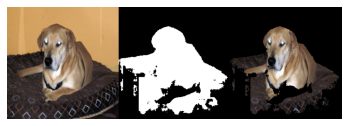

219/219 [==============================] - 69s 315ms/step - loss: 0.2009 - mean_iou: 0.0441 - val_loss: 0.1951 - val_mean_iou: 0.0320
Epoch 20/30
 11/219 [>.............................] - ETA: 34s - loss: 0.2284 - mean_iou: 0.0289i= 20 loss= 0.19209950788108182 val_loss= 0.22839773920449344 mean_iou= 0.041760493 val_mean_iou= 0.028926633


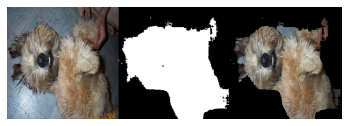

219/219 [==============================] - 69s 314ms/step - loss: 0.1921 - mean_iou: 0.0418 - val_loss: 0.2284 - val_mean_iou: 0.0289
Epoch 21/30
 11/219 [>.............................] - ETA: 34s - loss: 0.2575 - mean_iou: 0.0736i= 21 loss= 0.1930193890855737 val_loss= 0.25746145167134027 mean_iou= 0.041701272 val_mean_iou= 0.07358499


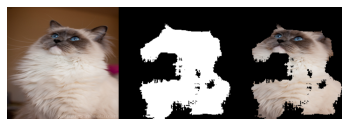

219/219 [==============================] - 69s 314ms/step - loss: 0.1930 - mean_iou: 0.0417 - val_loss: 0.2575 - val_mean_iou: 0.0736
Epoch 22/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2520 - mean_iou: 0.0292i= 22 loss= 0.18820861795041116 val_loss= 0.2519845407117497 mean_iou= 0.040494923 val_mean_iou= 0.029202906


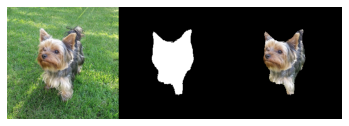

219/219 [==============================] - 69s 314ms/step - loss: 0.1882 - mean_iou: 0.0405 - val_loss: 0.2520 - val_mean_iou: 0.0292
Epoch 23/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2016 - mean_iou: 0.0441i= 23 loss= 0.18512180052935806 val_loss= 0.20160473205826498 mean_iou= 0.04005584 val_mean_iou= 0.04406688


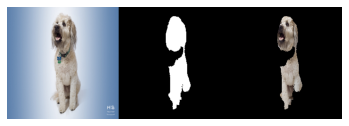

219/219 [==============================] - 69s 314ms/step - loss: 0.1851 - mean_iou: 0.0401 - val_loss: 0.2016 - val_mean_iou: 0.0441
Epoch 24/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2169 - mean_iou: 0.0388i= 24 loss= 0.17926265591900098 val_loss= 0.21685498411005194 mean_iou= 0.03838425 val_mean_iou= 0.03884685


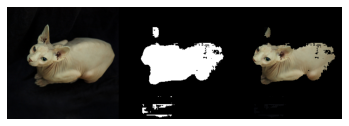

219/219 [==============================] - 69s 314ms/step - loss: 0.1793 - mean_iou: 0.0384 - val_loss: 0.2169 - val_mean_iou: 0.0388
Epoch 25/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2493 - mean_iou: 0.0225i= 25 loss= 0.1777150154317895 val_loss= 0.24929347498850388 mean_iou= 0.03779272 val_mean_iou= 0.022547795


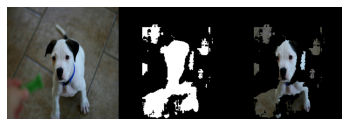

219/219 [==============================] - 69s 314ms/step - loss: 0.1777 - mean_iou: 0.0378 - val_loss: 0.2493 - val_mean_iou: 0.0225
Epoch 26/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2098 - mean_iou: 0.0418i= 26 loss= 0.17200068724618112 val_loss= 0.20983227545564825 mean_iou= 0.036601566 val_mean_iou= 0.041779097


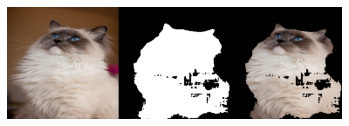

219/219 [==============================] - 69s 314ms/step - loss: 0.1720 - mean_iou: 0.0366 - val_loss: 0.2098 - val_mean_iou: 0.0418
Epoch 27/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2228 - mean_iou: 0.0293i= 27 loss= 0.17124066709383437 val_loss= 0.22277369553392584 mean_iou= 0.036257632 val_mean_iou= 0.029331775


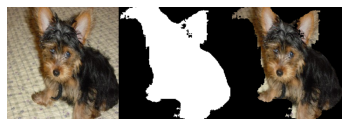

219/219 [==============================] - 69s 315ms/step - loss: 0.1712 - mean_iou: 0.0363 - val_loss: 0.2228 - val_mean_iou: 0.0293
Epoch 28/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2457 - mean_iou: 0.0519i= 28 loss= 0.16571782311620234 val_loss= 0.2457097267562693 mean_iou= 0.03488076 val_mean_iou= 0.05188115


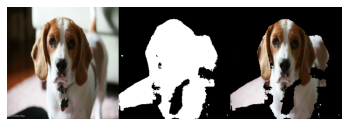

219/219 [==============================] - 69s 315ms/step - loss: 0.1657 - mean_iou: 0.0349 - val_loss: 0.2457 - val_mean_iou: 0.0519
Epoch 29/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2106 - mean_iou: 0.0302i= 29 loss= 0.16676167684466872 val_loss= 0.21056103029034354 mean_iou= 0.035136368 val_mean_iou= 0.030158777


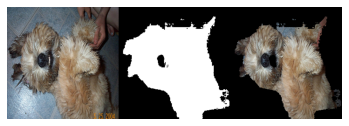

219/219 [==============================] - 69s 316ms/step - loss: 0.1668 - mean_iou: 0.0351 - val_loss: 0.2106 - val_mean_iou: 0.0302
Epoch 30/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2340 - mean_iou: 0.0718i= 30 loss= 0.16228937235188812 val_loss= 0.23395785282958637 mean_iou= 0.034065496 val_mean_iou= 0.07175673


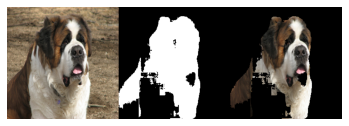

219/219 [==============================] - 69s 315ms/step - loss: 0.1623 - mean_iou: 0.0341 - val_loss: 0.2340 - val_mean_iou: 0.0718


In [16]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 1)

Epoch 1/30
 11/219 [>.............................] - ETA: 36s - loss: 0.4437 - mean_iou: 0.4668
i= 1 loss= 0.5692094787615075 val_loss= 0.4436972872777419 mean_iou= 0.21454653 val_mean_iou= 0.46682188


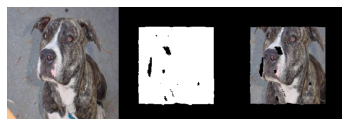

219/219 [==============================] - 71s 324ms/step - loss: 0.5692 - mean_iou: 0.2145 - val_loss: 0.4437 - val_mean_iou: 0.4668
Epoch 2/30
 11/219 [>.............................] - ETA: 36s - loss: 0.5779 - mean_iou: 0.4874
i= 2 loss= 0.44910586424614196 val_loss= 0.5779369419271295 mean_iou= 0.43584785 val_mean_iou= 0.48737222


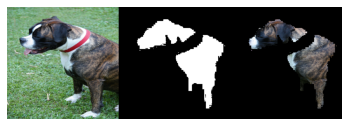

219/219 [==============================] - 69s 314ms/step - loss: 0.4491 - mean_iou: 0.4358 - val_loss: 0.5779 - val_mean_iou: 0.4874
Epoch 3/30
 11/219 [>.............................] - ETA: 35s - loss: 0.3573 - mean_iou: 0.5463
i= 3 loss= 0.4190039279526227 val_loss= 0.3572668026794087 mean_iou= 0.47365674 val_mean_iou= 0.54630685


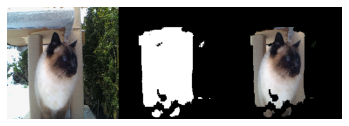

219/219 [==============================] - 69s 315ms/step - loss: 0.4190 - mean_iou: 0.4737 - val_loss: 0.3573 - val_mean_iou: 0.5463
Epoch 4/30
 11/219 [>.............................] - ETA: 35s - loss: 0.3603 - mean_iou: 0.5780
i= 4 loss= 0.381567380880112 val_loss= 0.360273691740903 mean_iou= 0.5211715 val_mean_iou= 0.5780448


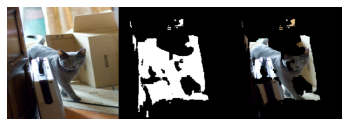

219/219 [==============================] - 69s 315ms/step - loss: 0.3816 - mean_iou: 0.5212 - val_loss: 0.3603 - val_mean_iou: 0.5780
Epoch 5/30
 11/219 [>.............................] - ETA: 35s - loss: 0.3355 - mean_iou: 0.5989
i= 5 loss= 0.34532808134817095 val_loss= 0.335473355921832 mean_iou= 0.5725171 val_mean_iou= 0.59892434


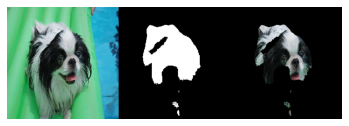

219/219 [==============================] - 69s 316ms/step - loss: 0.3453 - mean_iou: 0.5725 - val_loss: 0.3355 - val_mean_iou: 0.5989
Epoch 6/30
 11/219 [>.............................] - ETA: 35s - loss: 0.3702 - mean_iou: 0.6135
i= 6 loss= 0.3212586467804974 val_loss= 0.3701827688650651 mean_iou= 0.6050296 val_mean_iou= 0.6134983


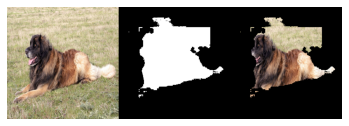

219/219 [==============================] - 69s 315ms/step - loss: 0.3213 - mean_iou: 0.6050 - val_loss: 0.3702 - val_mean_iou: 0.6135
Epoch 7/30
 11/219 [>.............................] - ETA: 36s - loss: 0.3597 - mean_iou: 0.4991
i= 7 loss= 0.303467998902003 val_loss= 0.35970755327831616 mean_iou= 0.62794626 val_mean_iou= 0.4991307


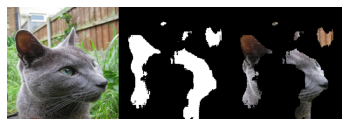

219/219 [==============================] - 69s 314ms/step - loss: 0.3035 - mean_iou: 0.6279 - val_loss: 0.3597 - val_mean_iou: 0.4991
Epoch 8/30
 11/219 [>.............................] - ETA: 36s - loss: 0.3049 - mean_iou: 0.6327
i= 8 loss= 0.28508031198151035 val_loss= 0.3048507815057581 mean_iou= 0.6510261 val_mean_iou= 0.632703


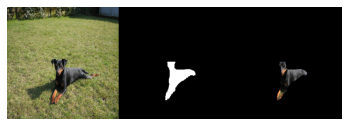

219/219 [==============================] - 69s 316ms/step - loss: 0.2851 - mean_iou: 0.6510 - val_loss: 0.3049 - val_mean_iou: 0.6327
Epoch 9/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2739 - mean_iou: 0.6089
i= 9 loss= 0.277503735398593 val_loss= 0.27387801896442066 mean_iou= 0.666961 val_mean_iou= 0.60885805


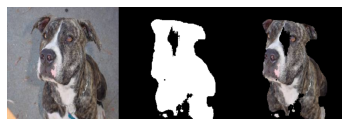

219/219 [==============================] - 69s 316ms/step - loss: 0.2775 - mean_iou: 0.6670 - val_loss: 0.2739 - val_mean_iou: 0.6089
Epoch 10/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2618 - mean_iou: 0.6327
i= 10 loss= 0.26158759508230917 val_loss= 0.2618263011628931 mean_iou= 0.6819408 val_mean_iou= 0.6326838


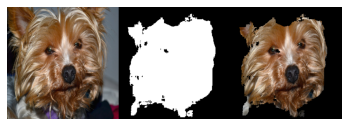

219/219 [==============================] - 69s 315ms/step - loss: 0.2616 - mean_iou: 0.6819 - val_loss: 0.2618 - val_mean_iou: 0.6327
Epoch 11/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2196 - mean_iou: 0.7090
i= 11 loss= 0.2524457098278281 val_loss= 0.21955237740820105 mean_iou= 0.6918538 val_mean_iou= 0.7090129


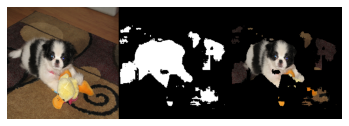

219/219 [==============================] - 69s 315ms/step - loss: 0.2524 - mean_iou: 0.6919 - val_loss: 0.2196 - val_mean_iou: 0.7090
Epoch 12/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2293 - mean_iou: 0.7048
i= 12 loss= 0.24068531128641676 val_loss= 0.22931156239726327 mean_iou= 0.70612437 val_mean_iou= 0.7048231


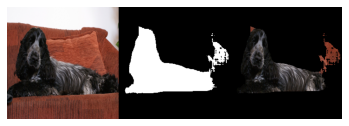

219/219 [==============================] - 69s 315ms/step - loss: 0.2407 - mean_iou: 0.7061 - val_loss: 0.2293 - val_mean_iou: 0.7048
Epoch 13/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2358 - mean_iou: 0.6797
i= 13 loss= 0.23175850027500222 val_loss= 0.2357506196607243 mean_iou= 0.71798545 val_mean_iou= 0.67973936


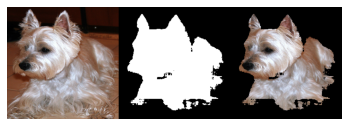

219/219 [==============================] - 69s 314ms/step - loss: 0.2318 - mean_iou: 0.7180 - val_loss: 0.2358 - val_mean_iou: 0.6797
Epoch 14/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2238 - mean_iou: 0.7191
i= 14 loss= 0.2267779232296225 val_loss= 0.22384466908194803 mean_iou= 0.72740227 val_mean_iou= 0.719087


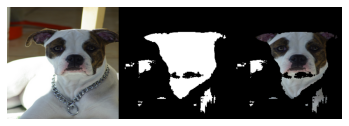

219/219 [==============================] - 69s 315ms/step - loss: 0.2268 - mean_iou: 0.7274 - val_loss: 0.2238 - val_mean_iou: 0.7191
Epoch 15/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2160 - mean_iou: 0.7131
i= 15 loss= 0.22002822956810258 val_loss= 0.2159652574495836 mean_iou= 0.7338988 val_mean_iou= 0.71309257


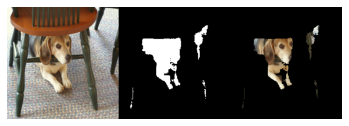

219/219 [==============================] - 69s 315ms/step - loss: 0.2200 - mean_iou: 0.7339 - val_loss: 0.2160 - val_mean_iou: 0.7131
Epoch 16/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2105 - mean_iou: 0.7246
i= 16 loss= 0.2126605316792449 val_loss= 0.21054112098433755 mean_iou= 0.74469835 val_mean_iou= 0.72462386


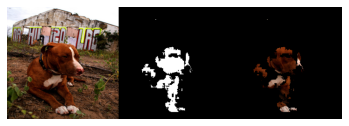

219/219 [==============================] - 69s 315ms/step - loss: 0.2127 - mean_iou: 0.7447 - val_loss: 0.2105 - val_mean_iou: 0.7246
Epoch 17/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2520 - mean_iou: 0.7025
i= 17 loss= 0.20816357229670432 val_loss= 0.2519893415949561 mean_iou= 0.7428491 val_mean_iou= 0.702501


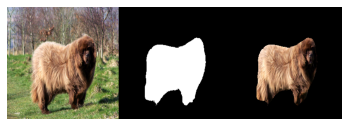

219/219 [==============================] - 69s 314ms/step - loss: 0.2082 - mean_iou: 0.7428 - val_loss: 0.2520 - val_mean_iou: 0.7025
Epoch 18/30
 11/219 [>.............................] - ETA: 35s - loss: 0.1977 - mean_iou: 0.7459
i= 18 loss= 0.2080038657335386 val_loss= 0.19773556833917444 mean_iou= 0.7493314 val_mean_iou= 0.7459421


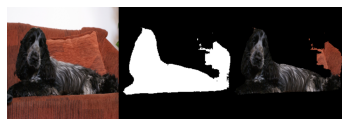

219/219 [==============================] - 69s 315ms/step - loss: 0.2080 - mean_iou: 0.7493 - val_loss: 0.1977 - val_mean_iou: 0.7459
Epoch 19/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2132 - mean_iou: 0.7186
i= 19 loss= 0.2013742827117171 val_loss= 0.2132312452251261 mean_iou= 0.7534531 val_mean_iou= 0.71862036


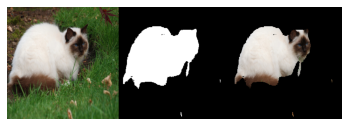

219/219 [==============================] - 69s 315ms/step - loss: 0.2014 - mean_iou: 0.7535 - val_loss: 0.2132 - val_mean_iou: 0.7186
Epoch 20/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2434 - mean_iou: 0.6716
i= 20 loss= 0.19606729307675472 val_loss= 0.24339367991144006 mean_iou= 0.7582768 val_mean_iou= 0.67162687


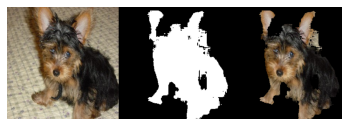

219/219 [==============================] - 69s 315ms/step - loss: 0.1961 - mean_iou: 0.7583 - val_loss: 0.2434 - val_mean_iou: 0.6716
Epoch 21/30
 11/219 [>.............................] - ETA: 36s - loss: 0.3239 - mean_iou: 0.5547
i= 21 loss= 0.19147240972682222 val_loss= 0.3238970799879594 mean_iou= 0.7645708 val_mean_iou= 0.5547232


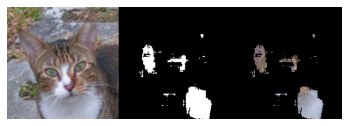

219/219 [==============================] - 69s 315ms/step - loss: 0.1915 - mean_iou: 0.7646 - val_loss: 0.3239 - val_mean_iou: 0.5547
Epoch 22/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2055 - mean_iou: 0.7457
i= 22 loss= 0.18616959809848707 val_loss= 0.20546840131282806 mean_iou= 0.7720689 val_mean_iou= 0.7456512


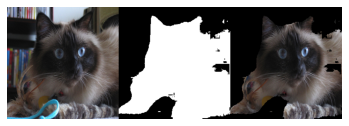

219/219 [==============================] - 69s 315ms/step - loss: 0.1862 - mean_iou: 0.7721 - val_loss: 0.2055 - val_mean_iou: 0.7457
Epoch 23/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2028 - mean_iou: 0.7504
i= 23 loss= 0.1821464603962419 val_loss= 0.2027891386638988 mean_iou= 0.7741448 val_mean_iou= 0.7503939


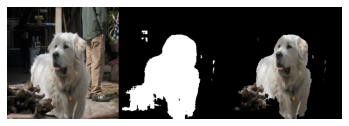

219/219 [==============================] - 69s 315ms/step - loss: 0.1821 - mean_iou: 0.7741 - val_loss: 0.2028 - val_mean_iou: 0.7504
Epoch 24/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2153 - mean_iou: 0.7492
i= 24 loss= 0.177280460692704 val_loss= 0.21530932594429364 mean_iou= 0.779934 val_mean_iou= 0.7491858


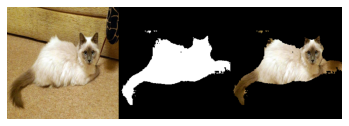

219/219 [==============================] - 69s 314ms/step - loss: 0.1773 - mean_iou: 0.7799 - val_loss: 0.2153 - val_mean_iou: 0.7492
Epoch 25/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2059 - mean_iou: 0.7522
i= 25 loss= 0.17474632614959865 val_loss= 0.20589177039536563 mean_iou= 0.78672737 val_mean_iou= 0.75220305


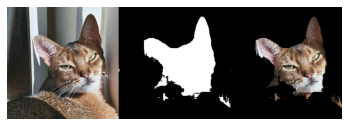

219/219 [==============================] - 69s 315ms/step - loss: 0.1747 - mean_iou: 0.7867 - val_loss: 0.2059 - val_mean_iou: 0.7522
Epoch 26/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2059 - mean_iou: 0.7267
i= 26 loss= 0.17064624715205198 val_loss= 0.20589217679067093 mean_iou= 0.79063326 val_mean_iou= 0.72669774


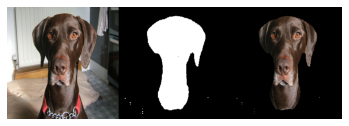

219/219 [==============================] - 69s 315ms/step - loss: 0.1706 - mean_iou: 0.7906 - val_loss: 0.2059 - val_mean_iou: 0.7267
Epoch 27/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2557 - mean_iou: 0.7118
i= 27 loss= 0.16969973631373278 val_loss= 0.25569313764572144 mean_iou= 0.79092413 val_mean_iou= 0.7117763


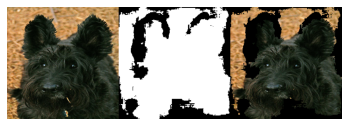

219/219 [==============================] - 69s 315ms/step - loss: 0.1697 - mean_iou: 0.7909 - val_loss: 0.2557 - val_mean_iou: 0.7118
Epoch 28/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2598 - mean_iou: 0.7249
i= 28 loss= 0.16671359879241143 val_loss= 0.25978832759640436 mean_iou= 0.7975242 val_mean_iou= 0.72490615


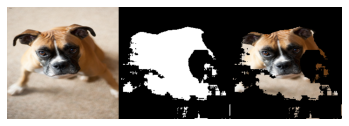

219/219 [==============================] - 69s 314ms/step - loss: 0.1667 - mean_iou: 0.7975 - val_loss: 0.2598 - val_mean_iou: 0.7249
Epoch 29/30
 11/219 [>.............................] - ETA: 36s - loss: 0.2594 - mean_iou: 0.6750
i= 29 loss= 0.16358557884415534 val_loss= 0.2593979943882335 mean_iou= 0.79702485 val_mean_iou= 0.67503375


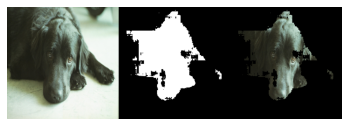

219/219 [==============================] - 69s 315ms/step - loss: 0.1636 - mean_iou: 0.7970 - val_loss: 0.2594 - val_mean_iou: 0.6750
Epoch 30/30
 11/219 [>.............................] - ETA: 35s - loss: 0.2331 - mean_iou: 0.7360
i= 30 loss= 0.1614895384061282 val_loss= 0.2330812093886462 mean_iou= 0.8009632 val_mean_iou= 0.73604643


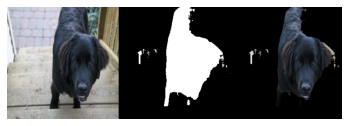

219/219 [==============================] - 69s 314ms/step - loss: 0.1615 - mean_iou: 0.8010 - val_loss: 0.2331 - val_mean_iou: 0.7360


In [34]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 1)

# Testing

In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

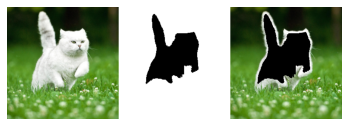

In [42]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 
mask = msk[:, :, 0, :]
#show the mask and the segmented image 
# combined = np.concatenate([raw, msk, raw* msk], axis = 1)
combined = np.concatenate([raw, mask, raw* mask], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

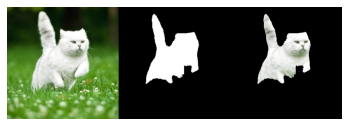

In [43]:
mask = msk[:, :, 1, :]
combined = np.concatenate([raw, mask, raw* mask], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

In [37]:
raw.shape, msk[:, :, 0, :].shape

((256, 256, 3), (256, 256, 3))

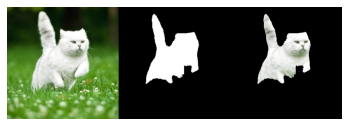

In [44]:
msk = pred[0]
msk = np.argmax(msk, axis=1)

msk = np.stack((msk,)*3, axis=-1)

combined = np.concatenate([raw, mask, raw* mask], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet



In [ ]:
# 녹색 선 = 3x3 convolutional
def Mnet(sz = (256, 256, 3)):
    
    nKernels = 16
    
    x = Input(sz)
    # (256, 256, 3)
    layer11 = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
    layer12 = Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer11)
    layer13 = Concatenate()([layer11, layer12])
    layer14 = Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer13)
    
    layer11p = MaxPooling2D()(layer11)
    layer14p = MaxPooling2D()(layer14)
    layer21 = Concatenate()([layer11p, layer14p])
    layer22 = Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer21)
    layer23 = Concatenate()([layer22, layer14p])
    layer24 = Conv2D(48, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(layer23)
    